In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import torch.optim as optim
from torch_geometric.nn.conv import feast_conv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [42]:
# Definition of the damped sine wave functions
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [44]:
#Time history specifics
dt = 0.01
T = 2
time = np.arange(0,T,dt)

data = []
current_group = []
with open('Data\\trussBridgeData2.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
displacement_z_data = np.array(data)

In [46]:
#Load truss data
data_set = torch.load("Data\\trussDataObjects2")
print(*data_set[120].y[4].tolist())

3.722881555557251 65.3381118774414 -1.9273717403411865 2.0692801475524902 1.3513010740280151 116.40330505371094 -2.1252148151397705 22.092056274414062


3.722881555557251 65.3381118774414 -1.9273717403411865 2.0692801475524902 1.3513010740280151 116.40330505371094 -2.1252148151397705 22.092056274414062


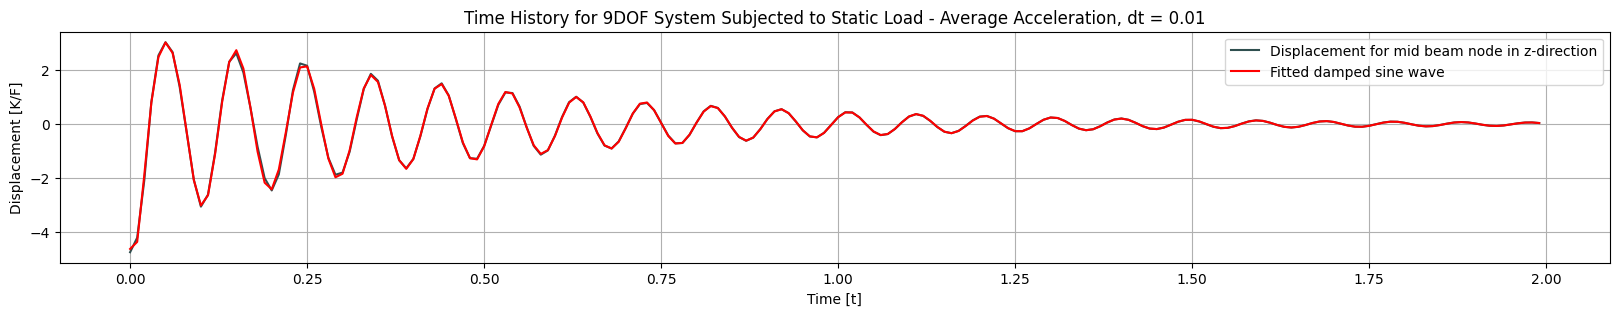

397


In [47]:
#Check an example
print(*data_set[120].y[4].tolist())
fitted = damped_sine_wave_2(time, *data_set[120].y[4].tolist())
id = data_set[120].bridge_id
original = displacement_z_data[id][4]

title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, original, color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(id)

In [52]:
import datetime
versj = 1
today = datetime.date.today().strftime("%b-%d")
print(today)

May-19


In [44]:
versj =2

In [53]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')

print("Using {}.".format(device_name))

Using cpu.


In [54]:
#Creating data sets

#80 percent training data
training_data = data_set[:int(len(data_set)*0.8)]
#10 percent validation data
validation_data = data_set[int(len(data_set)*0.8):int(0.9*len(data_set))]
#10 percent test data
test_data = data_set[int(0.9*len(data_set)):]
print(len(training_data))
print(len(validation_data))
print(len(test_data))
print(training_data[0].y.shape)

1696
212
213
torch.Size([32, 8])


In [55]:
#Definition of model

class TrussGNN(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class TrussGNN2(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN2, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.fc1 = nn.Linear(16, 32)
        self.conv1 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(512, 1024, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(1024, 128, heads=heads, t_inv=t_inv)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class TrussGNN3(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN3, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.fc1 = nn.Linear(16, 32)
        self.conv1 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(512, 1024, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(1024, 2048, heads=heads, t_inv=t_inv)
        self.conv7 = feast_conv.FeaStConv(2048, 4096, heads=heads, t_inv=t_inv)
        self.conv8 = feast_conv.FeaStConv(4096, 4096, heads=heads, t_inv=t_inv)
        self.conv9 = feast_conv.FeaStConv(4096, 2048, heads=heads, t_inv=t_inv)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()
        self.conv7.reset_parameters()
        self.conv8.reset_parameters()
        self.conv9.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.fc0(x))
        x = F.elu(self.fc1(x))
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = F.elu(self.conv9(x, edge_index))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

In [58]:
import time
import torch
import torch.nn.functional as F


def print_info(info):
    message = ('Epoch: {}/{}, Duration: {:.3f}s,'
               'Train Loss: {:.4f}, Test Loss:{:.4f}').format(
                   info['current_epoch'], info['epochs'], info['t_duration'],
                   info['train_loss'], info['test_loss'])
    print(message)


def run(model, train_loader, test_loader, num_nodes, epochs, optimizer, device):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        t = time.time()
        train_loss = train(model, train_loader, optimizer, device)
        t_duration = time.time() - t
        test_loss = test(model, test_loader, num_nodes, device)
        eval_info = {
            'train_loss': train_loss,
            'test_loss': test_loss,
            'current_epoch': epoch,
            'epochs': epochs,
            't_duration': t_duration
        }

        print_info(eval_info)
        test_losses.append(test_loss)
        train_losses.append(train_loss)
    return train_losses, test_losses


def train(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0
    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        # Calculate MSE loss for each item in output and labels
        losses = F.l1_loss(output, data.y.to(device))#, reduction='none')  
        # Compute mean loss for backpropagation
        loss = losses.mean()  
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(model, test_loader, num_nodes, device):
    model.eval()
    correct = 0
    total_loss = 0
    n_graphs = 0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            out = model(data.to(device))
            total_loss += F.l1_loss(out, data.y.to(device)).item()
    return total_loss / len(test_loader)

In [59]:
#runner
num_nodes = training_data[0].x.shape[0]
num_features = training_data[0].x.shape[1]

model3 = TrussGNN(num_features, num_nodes, heads=8).to(device_name)

optimizer = optim.Adam(model3.parameters(),
                       lr=0.0001)


train_losses, test_losses = \
run(model3, training_data, validation_data, num_nodes, 500, optimizer, device_name)

#versj defined at the top of the notebook
modelPath = "trained_models" + today + "TrussGNNVersion" + str(versj) +".pt"
trainLossPath = "trained_models" + today + "TrussGNNVersion" + str(versj) + "TrainLoss.txt"
testLossPath = "trained_models" + today + "TrussGNNVersion" + str(versj) + "TestLoss.txt"
np.savetxt(trainLossPath, np.array(train_losses))
np.savetxt(testLossPath, np.array(test_losses))
torch.save(model3.state_dict(), modelPath)
versj += 1
print("saved as: ", modelPath)

Epoch: 1/500, Duration: 149.639s,Train Loss: 843.1667, Test Loss:840.7570
Epoch: 2/500, Duration: 140.929s,Train Loss: 841.3066, Test Loss:839.9059
Epoch: 3/500, Duration: 163.656s,Train Loss: 840.9935, Test Loss:839.3132
Epoch: 4/500, Duration: 172.335s,Train Loss: 840.8906, Test Loss:839.9932


In [81]:
model_dict = torch.load("May-15TrussGNNVersion2.pt")
model.load_state_dict(model_dict)
model.eval()
print(*test_data[0].y[26].tolist())

print(model(test_data[0])[26])
labels = test_data[0].y[26].tolist()
print(*labels)


3.2879114151000977 85.93531036376953 -2.082348585128784 3.4927475452423096 2.749377965927124 -128.55718994140625 -1.2575898170471191 35.91775131225586
tensor([ 2.2058e+00,  7.1827e+01, -5.8500e+00,  8.9073e+00,  2.0028e+01,
        -9.9745e+02,  1.3834e+01,  1.1795e+04], grad_fn=<SelectBackward0>)
3.2879114151000977 85.93531036376953 -2.082348585128784 3.4927475452423096 2.749377965927124 -128.55718994140625 -1.2575898170471191 35.91775131225586


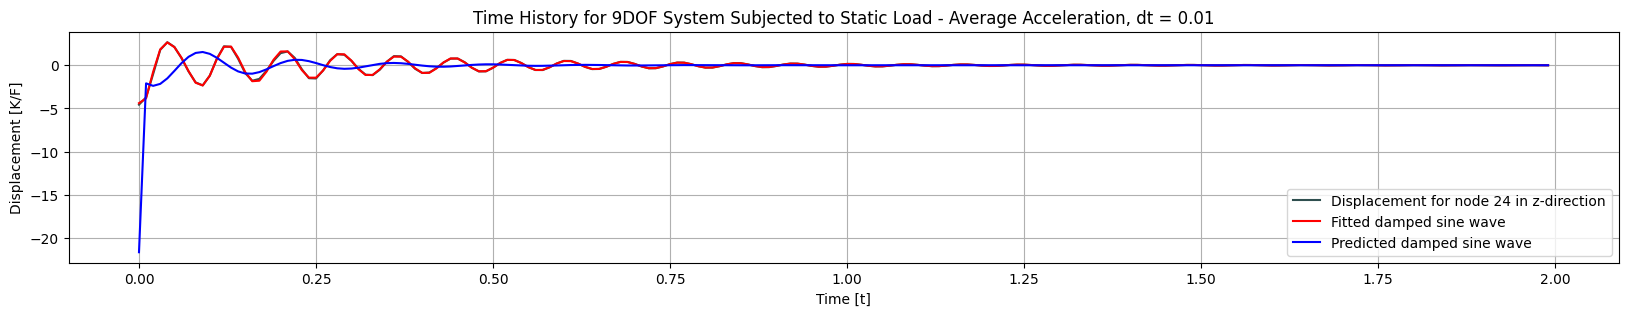

-21.63497369685386


In [109]:
dt = 0.01
T = 2
time = np.arange(0,T,dt)
nodenr = 24
bridgenr = 8

labels = test_data[bridgenr].y[nodenr].tolist()
predicted_params = model3(test_data[bridgenr])[nodenr].tolist()

fitted = damped_sine_wave_2(time, *labels)
id = test_data[bridgenr].id
original = displacement_z_data[id][nodenr]
prediction_fitted = damped_sine_wave_2(time, *predicted_params)


title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, original, color='darkslategrey', label='Displacement for node ' + str(nodenr) +' in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
plt.plot(time, prediction_fitted, 'b-', label='Predicted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(prediction_fitted[0])